# PM synchronous motor transient analysis

This example shows how to use PyAEDT to create a Maxwell 2D transient analysis for
an interior permanent magnet (PM) electric motor.

Keywords: **Maxwell 2D**, **transient**, **motor**.

## Perform imports and define constants

Perform required imports.

In [1]:
import csv
import os
import tempfile
import time
from operator import attrgetter

In [2]:
import ansys.aedt.core

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory and download files

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Initialize dictionaries

Dictionaries contain all the definitions for the design variables and output variables.

## Initialize definitions for th stator, rotor, and shaft

Initialize geometry parameter definitions for the stator, rotor, and shaft.
The naming refers to RMxprt primitives.

In [5]:
geom_params = {
    "DiaGap": "132mm",
    "DiaStatorYoke": "198mm",
    "DiaStatorInner": "132mm",
    "DiaRotorLam": "130mm",
    "DiaShaft": "44.45mm",
    "DiaOuter": "198mm",
    "Airgap": "1mm",
    "SlotNumber": "48",
    "SlotType": "3",
}

## Initialize definitions for stator windings

Initialize geometry parameter definitions for the stator windings. The naming
refers to RMxprt primitives.

In [6]:
wind_params = {
    "Layers": "1",
    "ParallelPaths": "2",
    "R_Phase": "7.5mOhm",
    "WdgExt_F": "5mm",
    "SpanExt": "30mm",
    "SegAngle": "0.25",
    "CoilPitch": "5",  # coil pitch in slots
    "Coil_SetBack": "3.605732823mm",
    "SlotWidth": "2.814mm",  # RMxprt Bs0
    "Coil_Edge_Short": "3.769235435mm",
    "Coil_Edge_Long": "15.37828521mm",
}

## Initialize definitions for model setup

Initialize geometry parameter definitions for the model setup.

In [7]:
mod_params = {
    "NumPoles": "8",
    "Model_Length": "80mm",
    "SymmetryFactor": "8",
    "Magnetic_Axial_Length": "150mm",
    "Stator_Lam_Length": "0mm",
    "StatorSkewAngle": "0deg",
    "NumTorquePointsPerCycle": "30",
    "mapping_angle": "0.125*4deg",
    "num_m": "16",
    "Section_Angle": "360deg/SymmetryFactor",
}

## Initialize definitions for operational machine

Initialize geometry parameter definitions for the operational machine. This
identifies the operating point for the transient setup.

In [8]:
oper_params = {
    "InitialPositionMD": "180deg/4",
    "IPeak": "480A",
    "MachineRPM": "3000rpm",
    "ElectricFrequency": "MachineRPM/60rpm*NumPoles/2*1Hz",
    "ElectricPeriod": "1/ElectricFrequency",
    "BandTicksinModel": "360deg/NumPoles/mapping_angle",
    "TimeStep": "ElectricPeriod/(2*BandTicksinModel)",
    "StopTime": "ElectricPeriod",
    "Theta_i": "135deg",
}

## Launch AEDT and Maxwell 2D

Launch AEDT and Maxwell 2D after first setting up the project and design names,
the solver, and the version. The following code also creates an instance of the
``Maxwell2d`` class named ``m2d``.

In [9]:
project_name = os.path.join(temp_folder.name, "PM_Motor.aedt")
m2d = ansys.aedt.core.Maxwell2d(
    project=project_name,
    version=AEDT_VERSION,
    design="Sinusoidal",
    solution_type="TransientXY",
    new_desktop=True,
    non_graphical=NG_MODE,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_20634555-a439-46cf-a5bb-d013dabb83e2.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 53521


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 4060.


PyAEDT INFO: Project PM_Motor has been created.


PyAEDT INFO: Added design 'Sinusoidal' of type Maxwell 2D.


PyAEDT INFO: Aedt Objects correctly read


## Define modeler units

In [10]:
m2d.modeler.model_units = "mm"

PyAEDT INFO: Modeler2D class has been initialized!


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


## Define variables from dictionaries

Define design variables from the created dictionaries.

In [11]:
for k, v in geom_params.items():
    m2d[k] = v
for k, v in wind_params.items():
    m2d[k] = v
for k, v in mod_params.items():
    m2d[k] = v
for k, v in oper_params.items():
    m2d[k] = v

## Define path for non-linear material properties

Define the path for non-linear material properties.
Materials are stored in text files.

In [12]:
filename_lam, filename_PM = ansys.aedt.core.downloads.download_leaf(
    destination=temp_folder.name
)

## Create first material

Create the material ``"Copper (Annealed)_65C"``.

In [13]:
mat_coils = m2d.materials.add_material("Copper (Annealed)_65C")
mat_coils.update()
mat_coils.conductivity = "49288048.9198"
mat_coils.permeability = "1"

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Adding new material to the Project Library: Copper (Annealed)_65C


PyAEDT INFO: Material has been added in Desktop.


## Create second material

Create the material ``"Arnold_Magnetics_N30UH_80C"``.
The BH curve is read from a tabbed CSV file. A list named ``BH_List_PM``
is created. This list is passed to the ``mat_PM.permeability.value``
variable.

In [14]:
mat_PM = m2d.materials.add_material(name="Arnold_Magnetics_N30UH_80C_new")
mat_PM.update()
mat_PM.conductivity = "555555.5556"
mat_PM.set_magnetic_coercivity(value=-800146.66287534, x=1, y=0, z=0)
mat_PM.mass_density = "7500"
BH_List_PM = []
with open(filename_PM) as f:
    reader = csv.reader(f, delimiter="\t")
    next(reader)
    for row in reader:
        BH_List_PM.append([float(row[0]), float(row[1])])
mat_PM.permeability.value = BH_List_PM

PyAEDT INFO: Adding new material to the Project Library: Arnold_Magnetics_N30UH_80C_new


PyAEDT INFO: Material has been added in Desktop.


## Create third material

Create the laminated material ``30DH_20C_smooth``.
This material has a BH curve and a core loss model,
which is set to electrical steel.

In [15]:
mat_lam = m2d.materials.add_material("30DH_20C_smooth")
mat_lam.update()
mat_lam.conductivity = "1694915.25424"
kh = 71.7180985413
kc = 0.25092214579
ke = 12.1625774023
kdc = 0.001
eq_depth = 0.001
mat_lam.set_electrical_steel_coreloss(kh, kc, ke, kdc, eq_depth)
mat_lam.mass_density = "7650"
BH_List_lam = []
with open(filename_lam) as f:
    reader = csv.reader(f, delimiter="\t")
    next(reader)
    for row in reader:
        BH_List_lam.append([float(row[0]), float(row[1])])
mat_lam.permeability.value = BH_List_lam

PyAEDT INFO: Adding new material to the Project Library: 30DH_20C_smooth


PyAEDT INFO: Material has been added in Desktop.


## Create geometry for stator

Create the geometry for the stator. It is created via
the RMxprt user-defined primitive (UDP). A list of lists is
created with the proper UDP parameters.

In [16]:
udp_par_list_stator = [
    ["DiaGap", "DiaGap"],
    ["DiaYoke", "DiaStatorYoke"],
    ["Length", "Stator_Lam_Length"],
    ["Skew", "StatorSkewAngle"],
    ["Slots", "SlotNumber"],
    ["SlotType", "SlotType"],
    ["Hs0", "1.2mm"],
    ["Hs01", "0mm"],
    ["Hs1", "0.4834227384999mm"],
    ["Hs2", "17.287669825502mm"],
    ["Bs0", "2.814mm"],
    ["Bs1", "4.71154109036mm"],
    ["Bs2", "6.9777285790998mm"],
    ["Rs", "2mm"],
    ["FilletType", "1"],
    ["HalfSlot", "0"],
    ["VentHoles", "0"],
    ["HoleDiaIn", "0mm"],
    ["HoleDiaOut", "0mm"],
    ["HoleLocIn", "0mm"],
    ["HoleLocOut", "0mm"],
    ["VentDucts", "0"],
    ["DuctWidth", "0mm"],
    ["DuctPitch", "0mm"],
    ["SegAngle", "0deg"],
    ["LenRegion", "Model_Length"],
    ["InfoCore", "0"],
]

stator_id = m2d.modeler.create_udp(
    dll="RMxprt/VentSlotCore.dll",
    parameters=udp_par_list_stator,
    library="syslib",
    name="my_stator",
)


## Assign properties to stator

Assign properties to the stator. The following code assigns
the ``material``, ``name``, ``color``, and  ``solve_inside`` properties.

In [17]:
m2d.assign_material(assignment=stator_id, material="30DH_20C_smooth")
stator_id.name = "Stator"
stator_id.color = (0, 0, 255)  # rgb

In [18]:
# to be reassigned: m2d.assign material puts False if not dielectric
stator_id.solve_inside = True

## Create outer and inner PMs

Create the outer and inner PMs and assign color to them.

In [19]:
IM1_points = [
    [56.70957112, 3.104886585, 0],
    [40.25081875, 16.67243502, 0],
    [38.59701538, 14.66621111, 0],
    [55.05576774, 1.098662669, 0],
]
OM1_points = [
    [54.37758185, 22.52393189, 0],
    [59.69688156, 9.68200639, 0],
    [63.26490432, 11.15992981, 0],
    [57.94560461, 24.00185531, 0],
]
IPM1_id = m2d.modeler.create_polyline(
    points=IM1_points,
    cover_surface=True,
    name="PM_I1",
    material="Arnold_Magnetics_N30UH_80C_new",
)
IPM1_id.color = (0, 128, 64)
OPM1_id = m2d.modeler.create_polyline(
    points=OM1_points,
    cover_surface=True,
    name="PM_O1",
    material="Arnold_Magnetics_N30UH_80C_new",
)
OPM1_id.color = (0, 128, 64)

## Create coordinate system for PMs

Create the coordinate system for the PMs.
In Maxwell 2D, you assign magnetization via the coordinate system.
The inputs are the object name, coordinate system name, and inner or outer magnetization.

In [20]:
def create_cs_magnets(pm_id, cs_name, point_direction):
    edges = sorted(pm_id.edges, key=attrgetter("length"), reverse=True)

    if point_direction == "outer":
        my_axis_pos = edges[0]
    elif point_direction == "inner":
        my_axis_pos = edges[1]

    m2d.modeler.create_face_coordinate_system(
        face=pm_id.faces[0],
        origin=pm_id.faces[0],
        axis_position=my_axis_pos,
        axis="X",
        name=cs_name,
    )
    pm_id.part_coordinate_system = cs_name
    m2d.modeler.set_working_coordinate_system("Global")

## Create coordinate system for PMs in face center

Create the coordinate system for PMs in the face center.

In [21]:
create_cs_magnets(IPM1_id, "CS_" + IPM1_id.name, "outer")
create_cs_magnets(OPM1_id, "CS_" + OPM1_id.name, "outer")

## Duplicate and mirror PMs

Duplicate and mirror the PMs along with the local coordinate system.

In [22]:
m2d.modeler.duplicate_and_mirror(
    assignment=[IPM1_id, OPM1_id],
    origin=[0, 0, 0],
    vector=[
        "cos((360deg/SymmetryFactor/2)+90deg)",
        "sin((360deg/SymmetryFactor/2)+90deg)",
        0,
    ],
)
id_PMs = m2d.modeler.get_objects_w_string(string_name="PM", case_sensitive=True)

## Create coils

In [23]:
coil_id = m2d.modeler.create_rectangle(
    origin=["DiaRotorLam/2+Airgap+Coil_SetBack", "-Coil_Edge_Short/2", 0],
    sizes=["Coil_Edge_Long", "Coil_Edge_Short", 0],
    name="Coil",
    material="Copper (Annealed)_65C",
)
coil_id.color = (255, 128, 0)
m2d.modeler.rotate(assignment=coil_id, axis="Z", angle="360deg/SlotNumber/2")
coil_id.duplicate_around_axis(
    axis="Z", angle="360deg/SlotNumber", clones="CoilPitch+1", create_new_objects=True
)
id_coils = m2d.modeler.get_objects_w_string(string_name="Coil", case_sensitive=True)

## Create shaft and region

In [24]:
region_id = m2d.modeler.create_circle(
    origin=[0, 0, 0],
    radius="DiaOuter/2",
    num_sides="SegAngle",
    is_covered=True,
    name="Region",
)
shaft_id = m2d.modeler.create_circle(
    origin=[0, 0, 0],
    radius="DiaShaft/2",
    num_sides="SegAngle",
    is_covered=True,
    name="Shaft",
)

## Create bands

Create the inner band, band, and outer band.

In [25]:
bandIN_id = m2d.modeler.create_circle(
    origin=[0, 0, 0],
    radius="(DiaGap - (1.5 * Airgap))/2",
    num_sides="mapping_angle",
    is_covered=True,
    name="Inner_Band",
)
bandMID_id = m2d.modeler.create_circle(
    origin=[0, 0, 0],
    radius="(DiaGap - (1.0 * Airgap))/2",
    num_sides="mapping_angle",
    is_covered=True,
    name="Band",
)
bandOUT_id = m2d.modeler.create_circle(
    origin=[0, 0, 0],
    radius="(DiaGap - (0.5 * Airgap))/2",
    num_sides="mapping_angle",
    is_covered=True,
    name="Outer_Band",
)

## Assign motion setup to object

Assign a motion setup to a ``Band`` object named ``RotatingBand_mid``.

In [26]:
m2d.assign_rotate_motion(
    assignment="Band",
    coordinate_system="Global",
    axis="Z",
    positive_movement=True,
    start_position="InitialPositionMD",
    angular_velocity="MachineRPM",
)

## Create list of vacuum objects

Create a list of vacuum objects and assign color.

In [27]:
vacuum_obj_id = [
    shaft_id,
    region_id,
    bandIN_id,
    bandMID_id,
    bandOUT_id,
]  # put shaft first
for item in vacuum_obj_id:
    item.color = (128, 255, 255)

## Create rotor

Create the rotor. Holes are specific to the lamination.
Allocated PMs are created.

In [28]:
rotor_id = m2d.modeler.create_circle(
    origin=[0, 0, 0],
    radius="DiaRotorLam/2",
    num_sides=0,
    name="Rotor",
    material="30DH_20C_smooth",
)

rotor_id.color = (0, 128, 255)
m2d.modeler.subtract(blank_list=rotor_id, tool_list=shaft_id, keep_originals=True)
void_small_1_id = m2d.modeler.create_circle(
    origin=[62, 0, 0], radius="2.55mm", num_sides=0, name="void1", material="vacuum"
)

m2d.modeler.duplicate_around_axis(
    assignment=void_small_1_id,
    axis="Z",
    angle="360deg/SymmetryFactor",
    clones=2,
    create_new_objects=False,
)

void_big_1_id = m2d.modeler.create_circle(
    origin=[29.5643, 12.234389332712, 0],
    radius="9.88mm/2",
    num_sides=0,
    name="void_big",
    material="vacuum",
)
m2d.modeler.subtract(
    blank_list=rotor_id,
    tool_list=[void_small_1_id, void_big_1_id],
    keep_originals=False,
)

slot_IM1_points = [
    [37.5302872, 15.54555396, 0],
    [55.05576774, 1.098662669, 0],
    [57.33637589, 1.25, 0],
    [57.28982158, 2.626565019, 0],
    [40.25081875, 16.67243502, 0],
]
slot_OM1_points = [
    [54.37758185, 22.52393189, 0],
    [59.69688156, 9.68200639, 0],
    [63.53825619, 10.5, 0],
    [57.94560461, 24.00185531, 0],
]
slot_IM_id = m2d.modeler.create_polyline(
    points=slot_IM1_points, cover_surface=True, name="slot_IM1", material="vacuum"
)
slot_OM_id = m2d.modeler.create_polyline(
    points=slot_OM1_points, cover_surface=True, name="slot_OM1", material="vacuum"
)

m2d.modeler.duplicate_and_mirror(
    assignment=[slot_IM_id, slot_OM_id],
    origin=[0, 0, 0],
    vector=[
        "cos((360deg/SymmetryFactor/2)+90deg)",
        "sin((360deg/SymmetryFactor/2)+90deg)",
        0,
    ],
)

id_holes = m2d.modeler.get_objects_w_string(string_name="slot_", case_sensitive=True)
m2d.modeler.subtract(rotor_id, id_holes, keep_originals=True)

True

## Create section of machine

Create a section of the machine. This allows you to take
advantage of symmetries.

In [29]:
object_list = [stator_id, rotor_id] + vacuum_obj_id
m2d.modeler.create_coordinate_system(
    origin=[0, 0, 0],
    reference_cs="Global",
    name="Section",
    mode="axis",
    x_pointing=["cos(360deg/SymmetryFactor)", "sin(360deg/SymmetryFactor)", 0],
    y_pointing=["-sin(360deg/SymmetryFactor)", "cos(360deg/SymmetryFactor)", 0],
)

m2d.modeler.set_working_coordinate_system("Section")
m2d.modeler.split(assignment=object_list, plane="ZX", sides="NegativeOnly")
m2d.modeler.set_working_coordinate_system("Global")
m2d.modeler.split(assignment=object_list, plane="ZX", sides="PositiveOnly")

['Stator,Rotor,Shaft,Region,Inner_Band,Band,Outer_Band']

## Create boundary conditions

Create independent and dependent boundary conditions.
Edges for assignment are picked by position.
The points for edge picking are in the airgap.

In [30]:
pos_1 = "((DiaGap - (1.0 * Airgap))/4)"
id_bc_1 = m2d.modeler.get_edgeid_from_position(
    position=[pos_1, 0, 0], assignment="Region"
)
id_bc_2 = m2d.modeler.get_edgeid_from_position(
    position=[
        pos_1 + "*cos((360deg/SymmetryFactor))",
        pos_1 + "*sin((360deg/SymmetryFactor))",
        0,
    ],
    assignment="Region",
)
m2d.assign_master_slave(
    independent=id_bc_1,
    dependent=id_bc_2,
    reverse_master=False,
    reverse_slave=True,
    same_as_master=False,
    boundary="Matching",
)

(<ansys.aedt.core.modules.boundary.BoundaryObject at 0x1cecb857fd0>,
 <ansys.aedt.core.modules.boundary.BoundaryObject at 0x1cecb8547c0>)

## Assign vector potential

Assign a vector potential of ``0`` to the second position.

In [31]:
pos_2 = "(DiaOuter/2)"
id_bc_az = m2d.modeler.get_edgeid_from_position(
    position=[
        pos_2 + "*cos((360deg/SymmetryFactor/2))",
        pos_2 + "*sin((360deg/SymmetryFactor)/2)",
        0,
    ],
    assignment="Region",
)
m2d.assign_vector_potential(
    assignment=id_bc_az, vector_value=0, boundary="VectorPotentialZero"
)

## Create excitations

Create excitations, defining phase currents for the windings.

In [32]:
ph_a_current = "IPeak * cos(2*pi*ElectricFrequency*time+Theta_i)"
ph_b_current = "IPeak * cos(2*pi * ElectricFrequency*time - 120deg+Theta_i)"
ph_c_current = "IPeak * cos(2*pi * ElectricFrequency*time - 240deg+Theta_i)"

## Define windings in phase A

In [33]:
m2d.assign_coil(
    assignment=["Coil"],
    conductors_number=6,
    polarity="Positive",
    name="CT_Ph1_P2_C1_Go",
)
m2d.assign_coil(
    assignment=["Coil_5"],
    conductors_number=6,
    polarity="Negative",
    name="CT_Ph1_P2_C1_Ret",
)
m2d.assign_winding(
    assignment=None,
    winding_type="Current",
    is_solid=False,
    current=ph_a_current,
    parallel_branches=1,
    name="Phase_A",
)
m2d.add_winding_coils(
    assignment="Phase_A", coils=["CT_Ph1_P2_C1_Go", "CT_Ph1_P2_C1_Ret"]
)

True

## Define windings in phase B

In [34]:
m2d.assign_coil(
    assignment="Coil_3",
    conductors_number=6,
    polarity="Positive",
    name="CT_Ph3_P1_C2_Go",
)
m2d.assign_coil(
    assignment="Coil_4",
    conductors_number=6,
    polarity="Positive",
    name="CT_Ph3_P1_C1_Go",
)
m2d.assign_winding(
    assignment=None,
    winding_type="Current",
    is_solid=False,
    current=ph_b_current,
    parallel_branches=1,
    name="Phase_B",
)
m2d.add_winding_coils(
    assignment="Phase_B", coils=["CT_Ph3_P1_C2_Go", "CT_Ph3_P1_C1_Go"]
)

True

## Define windings in phase C

In [35]:
m2d.assign_coil(
    assignment="Coil_1",
    conductors_number=6,
    polarity="Negative",
    name="CT_Ph2_P2_C2_Ret",
)
m2d.assign_coil(
    assignment="Coil_2",
    conductors_number=6,
    polarity="Negative",
    name="CT_Ph2_P2_C1_Ret",
)
m2d.assign_winding(
    assignment=None,
    winding_type="Current",
    is_solid=False,
    current=ph_c_current,
    parallel_branches=1,
    name="Phase_C",
)
m2d.add_winding_coils(
    assignment="Phase_C", coils=["CT_Ph2_P2_C2_Ret", "CT_Ph2_P2_C1_Ret"]
)

True

## Assign total current on PMs

Assign a total current of ``0`` on the PMs.

In [36]:
PM_list = id_PMs
for item in PM_list:
    m2d.assign_current(assignment=item, amplitude=0, solid=True, name=item + "_I0")

## Create mesh operations

In [37]:
m2d.mesh.assign_length_mesh(
    assignment=id_coils,
    inside_selection=True,
    maximum_length=3,
    maximum_elements=None,
    name="coils",
)
m2d.mesh.assign_length_mesh(
    assignment=stator_id,
    inside_selection=True,
    maximum_length=3,
    maximum_elements=None,
    name="stator",
)
m2d.mesh.assign_length_mesh(
    assignment=rotor_id,
    inside_selection=True,
    maximum_length=3,
    maximum_elements=None,
    name="rotor",
)

PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Mesh class has been initialized! Elapsed time: 0m 0sec


## Turn on core loss

In [38]:
core_loss_list = ["Rotor", "Stator"]
m2d.set_core_losses(core_loss_list, core_loss_on_field=True)

True

## Compute transient inductance

In [39]:
m2d.change_inductance_computation(
    compute_transient_inductance=True, incremental_matrix=False
)

True

## Set model depth

In [40]:
m2d.model_depth = "Magnetic_Axial_Length"

## Set symmetry factor

In [41]:
m2d.change_symmetry_multiplier("SymmetryFactor")

True

## Create setup and validate

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpgwushm1s.ansys/PM_Motor.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpgwushm1s.ansys/PM_Motor.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015624523162841797


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


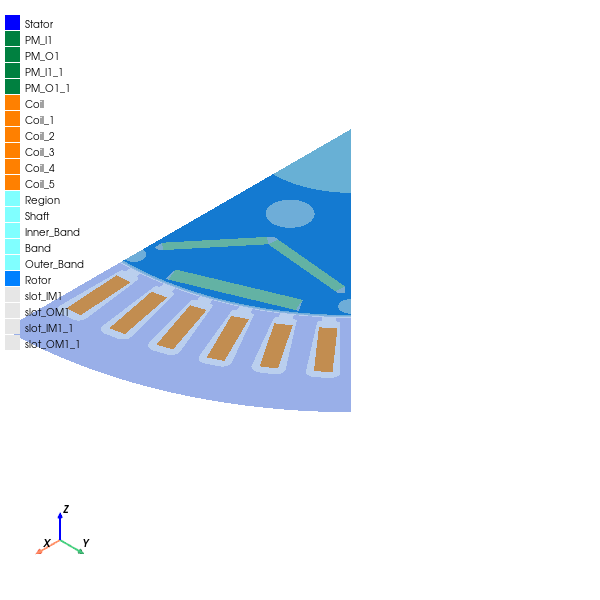

True

In [42]:
setup_name = "MySetupAuto"
setup = m2d.create_setup(name=setup_name)
setup.props["StopTime"] = "StopTime"
setup.props["TimeStep"] = "TimeStep"
setup.props["SaveFieldsType"] = "None"
setup.props["OutputPerObjectCoreLoss"] = True
setup.props["OutputPerObjectSolidLoss"] = True
setup.props["OutputError"] = True
setup.update()
m2d.validate_simple()

model = m2d.plot(show=False)
model.plot(os.path.join(temp_folder.name, "Image.jpg"))

## Initialize definitions for output variables

Initialize the definitions for the output variables.
These are used later to generate reports.

In [43]:
output_vars = {
    "Current_A": "InputCurrent(Phase_A)",
    "Current_B": "InputCurrent(Phase_B)",
    "Current_C": "InputCurrent(Phase_C)",
    "Flux_A": "FluxLinkage(Phase_A)",
    "Flux_B": "FluxLinkage(Phase_B)",
    "Flux_C": "FluxLinkage(Phase_C)",
    "pos": "(Moving1.Position -InitialPositionMD) *NumPoles/2",
    "cos0": "cos(pos)",
    "cos1": "cos(pos-2*PI/3)",
    "cos2": "cos(pos-4*PI/3)",
    "sin0": "sin(pos)",
    "sin1": "sin(pos-2*PI/3)",
    "sin2": "sin(pos-4*PI/3)",
    "Flux_d": "2/3*(Flux_A*cos0+Flux_B*cos1+Flux_C*cos2)",
    "Flux_q": "-2/3*(Flux_A*sin0+Flux_B*sin1+Flux_C*sin2)",
    "I_d": "2/3*(Current_A*cos0 + Current_B*cos1 + Current_C*cos2)",
    "I_q": "-2/3*(Current_A*sin0 + Current_B*sin1 + Current_C*sin2)",
    "Irms": "sqrt(I_d^2+I_q^2)/sqrt(2)",
    "ArmatureOhmicLoss_DC": "Irms^2*R_phase",
    "Lad": "L(Phase_A,Phase_A)*cos0 + L(Phase_A,Phase_B)*cos1 + L(Phase_A,Phase_C)*cos2",
    "Laq": "L(Phase_A,Phase_A)*sin0 + L(Phase_A,Phase_B)*sin1 + L(Phase_A,Phase_C)*sin2",
    "Lbd": "L(Phase_B,Phase_A)*cos0 + L(Phase_B,Phase_B)*cos1 + L(Phase_B,Phase_C)*cos2",
    "Lbq": "L(Phase_B,Phase_A)*sin0 + L(Phase_B,Phase_B)*sin1 + L(Phase_B,Phase_C)*sin2",
    "Lcd": "L(Phase_C,Phase_A)*cos0 + L(Phase_C,Phase_B)*cos1 + L(Phase_C,Phase_C)*cos2",
    "Lcq": "L(Phase_C,Phase_A)*sin0 + L(Phase_C,Phase_B)*sin1 + L(Phase_C,Phase_C)*sin2",
    "L_d": "(Lad*cos0 + Lbd*cos1 + Lcd*cos2) * 2/3",
    "L_q": "(Laq*sin0 + Lbq*sin1 + Lcq*sin2) * 2/3",
    "OutputPower": "Moving1.Speed*Moving1.Torque",
    "Ui_A": "InducedVoltage(Phase_A)",
    "Ui_B": "InducedVoltage(Phase_B)",
    "Ui_C": "InducedVoltage(Phase_C)",
    "Ui_d": "2/3*(Ui_A*cos0 + Ui_B*cos1 + Ui_C*cos2)",
    "Ui_q": "-2/3*(Ui_A*sin0 + Ui_B*sin1 + Ui_C*sin2)",
    "U_A": "Ui_A+R_Phase*Current_A",
    "U_B": "Ui_B+R_Phase*Current_B",
    "U_C": "Ui_C+R_Phase*Current_C",
    "U_d": "2/3*(U_A*cos0 + U_B*cos1 + U_C*cos2)",
    "U_q": "-2/3*(U_A*sin0 + U_B*sin1 + U_C*sin2)",
}

## Create output variables for postprocessing

In [44]:
for k, v in output_vars.items():
    m2d.create_output_variable(k, v)

## Initialize definition for postprocessing plots

In [45]:
post_params = {"Moving1.Torque": "TorquePlots"}

## Initialize definition for postprocessing multiplots

In [46]:
post_params_multiplot = {  # reports
    ("U_A", "U_B", "U_C", "Ui_A", "Ui_B", "Ui_C"): "PhaseVoltages",
    ("CoreLoss", "SolidLoss", "ArmatureOhmicLoss_DC"): "Losses",
    (
        "InputCurrent(Phase_A)",
        "InputCurrent(Phase_B)",
        "InputCurrent(Phase_C)",
    ): "PhaseCurrents",
    (
        "FluxLinkage(Phase_A)",
        "FluxLinkage(Phase_B)",
        "FluxLinkage(Phase_C)",
    ): "PhaseFluxes",
    ("I_d", "I_q"): "Currents_dq",
    ("Flux_d", "Flux_q"): "Fluxes_dq",
    ("Ui_d", "Ui_q"): "InducedVoltages_dq",
    ("U_d", "U_q"): "Voltages_dq",
    (
        "L(Phase_A,Phase_A)",
        "L(Phase_B,Phase_B)",
        "L(Phase_C,Phase_C)",
        "L(Phase_A,Phase_B)",
        "L(Phase_A,Phase_C)",
        "L(Phase_B,Phase_C)",
    ): "PhaseInductances",
    ("L_d", "L_q"): "Inductances_dq",
    ("CoreLoss", "CoreLoss(Stator)", "CoreLoss(Rotor)"): "CoreLosses",
    (
        "EddyCurrentLoss",
        "EddyCurrentLoss(Stator)",
        "EddyCurrentLoss(Rotor)",
    ): "EddyCurrentLosses (Core)",
    ("ExcessLoss", "ExcessLoss(Stator)", "ExcessLoss(Rotor)"): "ExcessLosses (Core)",
    (
        "HysteresisLoss",
        "HysteresisLoss(Stator)",
        "HysteresisLoss(Rotor)",
    ): "HysteresisLosses (Core)",
    (
        "SolidLoss",
        "SolidLoss(IPM1)",
        "SolidLoss(IPM1_1)",
        "SolidLoss(OPM1)",
        "SolidLoss(OPM1_1)",
    ): "SolidLoss",
}

## Create report.

In [47]:
for k, v in post_params.items():
    m2d.post.create_report(
        expressions=k,
        setup_sweep_name="",
        domain="Sweep",
        variations=None,
        primary_sweep_variable="Time",
        secondary_sweep_variable=None,
        report_category=None,
        plot_type="Rectangular Plot",
        context=None,
        subdesign_id=None,
        polyline_points=1001,
        plot_name=v,
    )

## Create multiplot report

In [48]:
# for k, v in post_params_multiplot.items():
#     m2d.post.create_report(expressions=list(k), setup_sweep_name="",
#                            domain="Sweep", variations=None,
#                            primary_sweep_variable="Time", secondary_sweep_variable=None,
#                            report_category=None, plot_type="Rectangular Plot",
#                            context=None, subdesign_id=None,
#                            polyline_points=1001, plotname=v)

## Analyze and save project

In [49]:
m2d.save_project()
m2d.analyze_setup(setup_name, use_auto_settings=False, cores=NUM_CORES)

PyAEDT INFO: Project PM_Motor Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Maxwell 2D correctly changed.


PyAEDT INFO: Solving design setup MySetupAuto


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Maxwell 2D correctly changed.


PyAEDT INFO: Design setup MySetupAuto solved correctly in 0.0h 2.0m 44.0s


True

## Create flux lines plot on region

Create a flux lines plot on a region. The ``object_list`` is
formerly created when the section is applied.

In [50]:
faces_reg = m2d.modeler.get_object_faces(object_list[1].name)  # Region
plot1 = m2d.post.create_fieldplot_surface(
    assignment=faces_reg,
    quantity="Flux_Lines",
    intrinsics={"Time": m2d.variable_manager.variables["StopTime"].evaluated_value},
    plot_name="Flux_Lines",
)

## Export a field plot to an image file

Export the flux lines plot to an image file using Python PyVista.

In [51]:
m2d.post.plot_field_from_fieldplot(plot1.name, show=False)

## Get solution data

Get a simulation result from a solved setup and cast it in a ``SolutionData`` object.
Plot the desired expression by using the Matplotlib ``plot()`` function.

In [52]:
solutions = m2d.post.get_solution_data(
    expressions="Moving1.Torque", primary_sweep_variable="Time"
)
# solutions.plot()

PyAEDT INFO: Solution Data Correctly Loaded.


## Retrieve the data magnitude of an expression

List of shaft torque points and compute average.

In [53]:
mag = solutions.data_magnitude()
avg = sum(mag) / len(mag)

## Export a report to a file

Export 2D plot data to a CSV file.

In [54]:
m2d.post.export_report_to_file(
    output_dir=temp_folder.name, plot_name="TorquePlots", extension=".csv"
)

'C:\\Users\\ansys\\AppData\\Local\\Temp\\tmpgwushm1s.ansys\\TorquePlots.csv'

## Release AEDT

In [55]:
m2d.save_project()
m2d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project PM_Motor Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [56]:
temp_folder.cleanup()